In [1]:
# Copyright 2023, Acadential, All rights reserved.

In [2]:
%matplotlib inline

# 8-6. PyTorch로 구현해보는 Optimization

이번에는 Neural Network 모델을 학습시키는 과정 (Optimization) 에 대해서 살펴보겠습니다

## Optimization의 구성: Training, Validation, Test

일반적으로 뉴럴넷의 학습 과정은 총 **3가지 단계**로 나눌 수 있습니다:
1. **Training**: training dataset에 대해서 학습시키는 과정
2. **Validation**: 각 training epoch이 끝난 후 validation dataset에 대해서 evaluation하는 과정.
    - 참고로, 여기서 계산된 validation 성능이 hyperparameter tuning이나 early stopping에 사용됩니다.
3. **Test**: 학습이 완료된 후 best checkpoint의 모델로 test dataset에 대해서 evaluation하는 과정.
    - Validation 성능도 hyperparameter tuning에 의해서 unintentionally overfit될 수 있으므로
    - 최종 일반화 generalization 성능을 test set로부터 확인합니다.

## Mini-batch이란
참고로,
딥러닝 모델은 한번에 모든 데이터셋을 한번에 forward pass하기에는 Memory 및 Computational cost 문제와 Generalization 문제가 있습니다. \
따라서, train dataset을 여러 개의 mini-batch들로 쪼개서 mini-batch 단위로 Gradient Descent을 수행합니다. \
즉, train dataset은 여러 개의 mini-batch들로 "쪼개어져" 구성되어 있습니다. \
예를 들어 8000개의 data로 구성된 train dataset이 있고, mini-batch의 크기가 8로 학습할 경우, 총 (8000/8) 1000개의 mini-batch들로 구성됨 셈입니다. \
이 때 mini-batch gradient descent을 전체 train dataset에 대해서 (즉, 1000개의 mini-batch들을) 한 차례 다 수행하는 것을 하나의 epoch이라고 합니다.

## Epoch
= train dataset에 대해서 한 차례 학습한 것.

하지만 한 번의 training epoch을 거쳐도 local optima 혹은 global optimum에 충분히 수렴하지 않을 수 있습니다. \
(Learning rate가 너무 작거나 saddle point들 때문에) \
따라서 모델이 충분히 수렴하고 validation dataset에 대한 성능이 더 이상 개선되지 않을 때까지 여러 번의 training epoch을 반복해 줍니다.

In [23]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Model

- `nn.Conv2d`은 Convolutional Neural Network Layer로 이미지 데이터에 대해서 흔히 사용되는 뉴럴넷 Layer이고, 섹션 14에서 더 자세히 배우게 됩니다.
- `nn.BatchNorm2d`은 Batch Normalization Layer로 학습 안정화에 기여하고, 섹션 13에서  더 자세히 배우게 됩니다.
- `nn.AvgPool2d`은 Pooling Layer인데 feature를 down sampling할때 사용되고, 섹션 14에서 더 자세히 배우게 됩니다.
- `_init_weights`함수에 등장하는 `weight.data.normal_`, `kaiming_uniform_` 등등은 Layer의 weight parameter들을 random하게 initialize하는 방법이고 섹션 12에서 더 자세히 다루게 됩니다.

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2), # 32 // 2 -> 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),  # 16 // 2 -> 8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),  # 8 // 2 -> 4
            nn.Flatten(),
            nn.Linear(64*4*4, 10),
            nn.Softmax()
        )
        
        for layer in self.conv:
            self._init_weights(layer)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        logits = self.conv(x)
        return logits
    

In [26]:
model = NeuralNetwork().to(device)  # (Conv2d → BatchNorm → ReLU → AvgPool2d)
print(model)

NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1024, out_features=10, bias=True)
    (14): Softmax(dim=None)
  )
)


## Dataset

In [27]:
training_data = datasets.CIFAR10(
    root="../.cache",
    train=True,
    download=False,
    transform=ToTensor()
)

train_len = int(len(training_data) * 0.8)
valid_len = len(training_data) - train_len

train_data, valid_data = torch.utils.data.random_split(training_data, [train_len, valid_len])

test_data = datasets.CIFAR10(
    root="../.cache",
    train=False,
    download=False,
    transform=ToTensor()
)

labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}


## DataLoader

In [28]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## Hyperparameters (초매개변수)

Gradient Descent은 모델의 매개변수(parameter e.g. weights, bias)을 최적화합니다. 반면에 Hyperparameter은 모델의 전반적인 학습 과정에 영향을 주는 매개변수들입니다. \
Hyperparameter에 따라 학습의 수렴 속도, Test set에 대한 일반화 성능 등등을 결정하게 됩니다.

이 프로젝트에서 사용되는 hyperparameter로는 다음과 같습니다:

 - **Number of Epochs** (Epoch의 개수) - 학습 데이터셋에 대한 학습 반복 횟수.
 - **Batch Size** (mini-batch의 크기) - Gradient Descent에 사용될 mini-batch의 크기.
 - **Learning Rate** (학습 속도) - Gradient Descent에서의 learning rate

가장 적절한 / 적합한 (수렴속도가 적절하고 가장 높은 일반화 성능을 성취하는) hyperparameter 값들의 조합은 데이터셋, 모델의 특징에 따라 다를 수 있습니다. \
따라서 Hyperparameter tuning을 통해서 가장 적합한 hyperparameter 값들의 조합을 탐색합니다. \

Hyperparameter tuning = 여러 조합의 hyperparameter들로 training, validation을 반복해서 validation 성능이 가장 높은 Hyperparameter 조합을 찾는 것.

Hyperparameter tuning의 예시
- Grid search
- Bayesian optimization
- 등등

하지만 주의할 점은 unintentional overfitting입니다! \
Hyperparameter tuning을 너무 많이 수행하게되면 validation set에 대해서 unintentionally (무의식적으로) overfitting할 수 있습니다. \
Coin flipping의 예시를 생각해 볼 수 있습니다.

In [29]:
learning_rate = 1e-3
batch_size = 64
epochs = 100

## Optimization Loop

일반적으로 하나의 epoch (Optimization loop)은 **Train loop** (trainig) 과 **Validation loop** (validation) 으로 구성되어 있습니다. \
모델의 최종 generalization performance은 test set로부터 확인합니다 (**Test loop**).


## Optimizer

이론편에서 다양한 optimizer들에 대해서 살펴보았습니다

참고로, PyTorch에서 optimizer들은 다 기본적으로 Mini-batch 기반의 optimizer들입니다.

PyTorch의 Optimizer (torch.optim):
1. Adadelta
2. Adagrad
3. Adam
4. RMSprop
5. SGD, ...

https://pytorch.org/docs/stable/optim.html

이 tutorial에서는 Mini-batch Stochastic Gradient Descent (Mini-batch SGD)을 사용해봅시다. 

<!-- 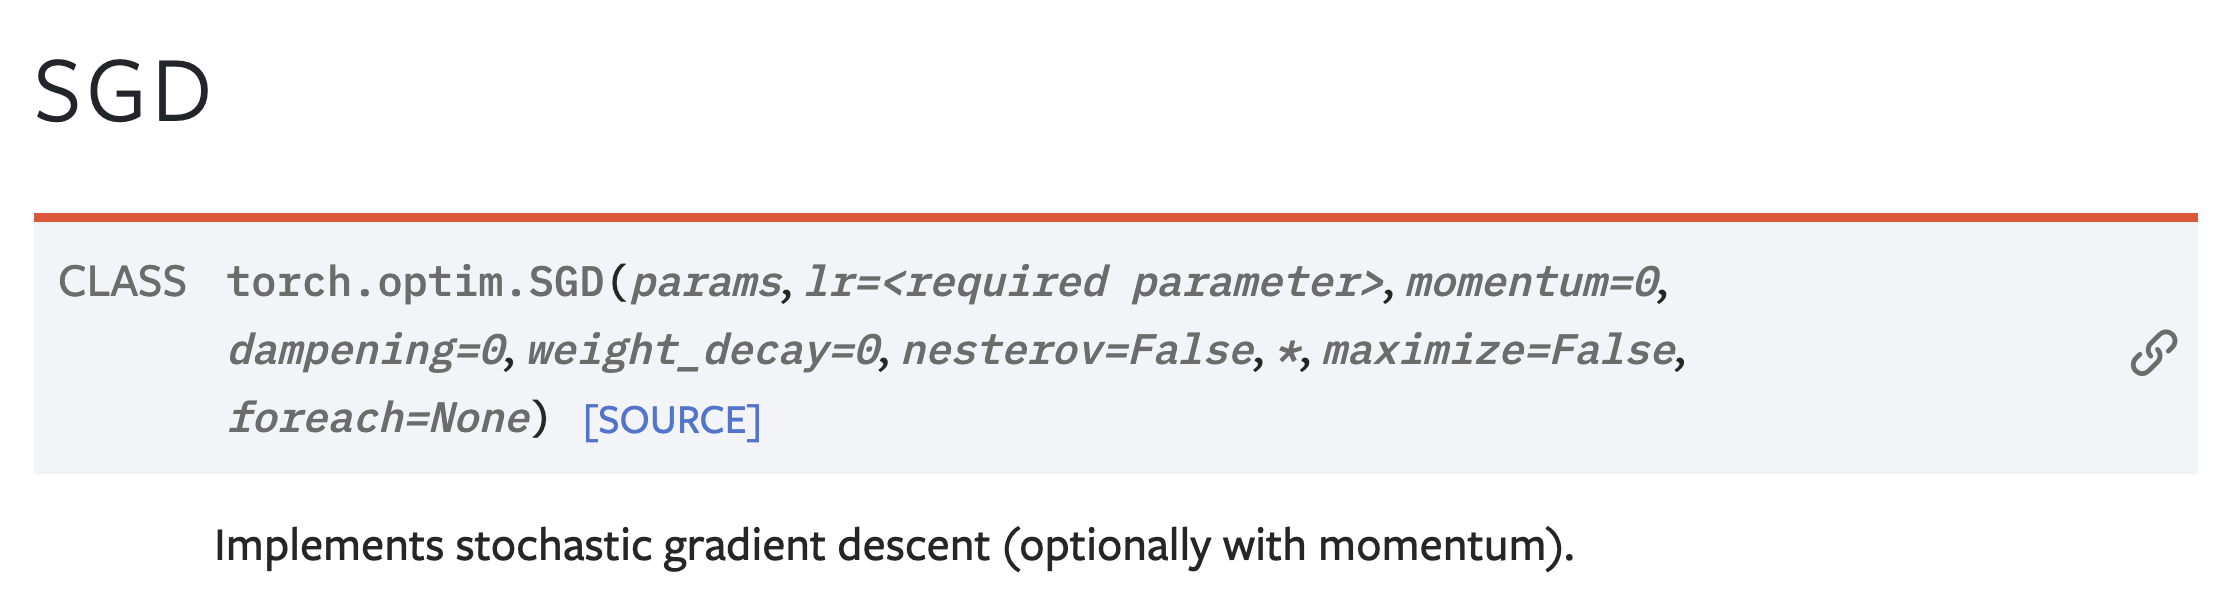 -->

<div>
<center>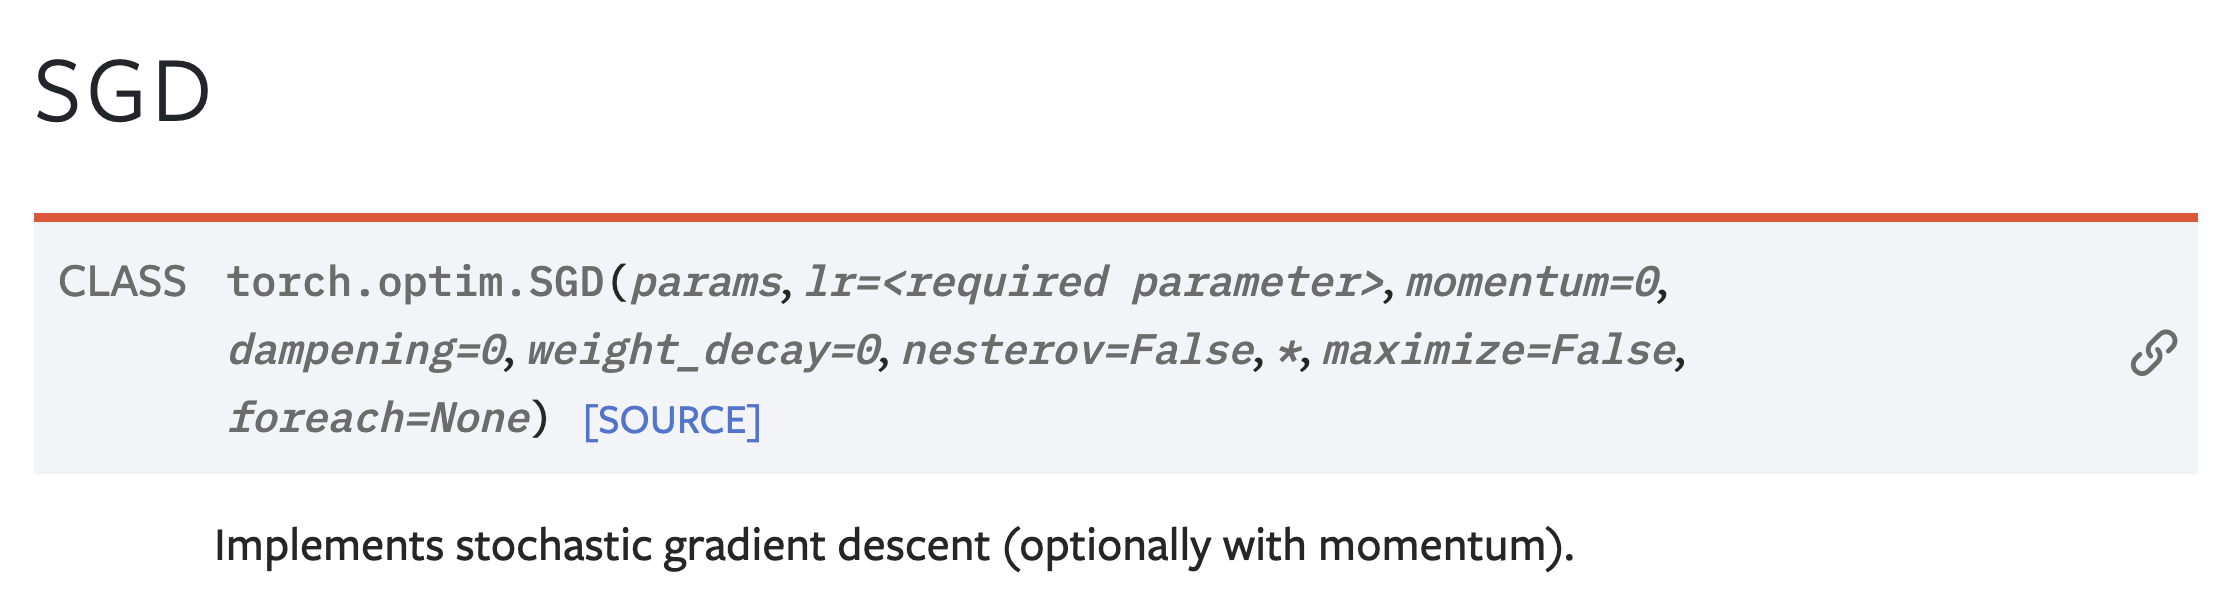</center>
<div>

In [30]:
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate)

## Overview of Optimization
모델의 학습 과정은 기본적으로 다음과 같이 구성됩니다:

즉, 다음과 같이 구성되어 있습니다! 
1. **epoch에 대한 iteration** \
    1-1. **Train dataset의 mini-batch에 대한 iteration** \
    1-2. **Valid dataset의 mini-batch에 대한 iteration**
2. **Test dataset의 mini-batch에 대한 iteration**

In [31]:
from tqdm import tqdm 

In [32]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    tbar = tqdm(dataloader)
    for batch, (X, y) in enumerate(tbar):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * len(X)
        tbar.set_description(f"loss: {loss:>7f}")

def test_loop(dataloader, model, loss_fn, mode="Valid"):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"{mode} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    valid_correct = test_loop(valid_dataloader, model, loss_fn, "Valid")
    
test_correct = test_loop(test_dataloader, model, loss_fn, "Test")
print("Done!")

Epoch 1
-------------------------------


  0%|                                | 0/625 [00:00<?, ?it/s]/Users/jeunghyunbyun/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
loss: 2.371470: 100%|██████| 625/625 [00:24<00:00, 25.83it/s]


Valid Error: 
 Accuracy: 9.6%, Avg loss: 2.356927 

Epoch 2
-------------------------------


loss: 2.286728: 100%|██████| 625/625 [00:24<00:00, 25.87it/s]


Valid Error: 
 Accuracy: 12.6%, Avg loss: 2.328171 

Epoch 3
-------------------------------


loss: 2.325366: 100%|██████| 625/625 [00:24<00:00, 25.18it/s]


Valid Error: 
 Accuracy: 17.6%, Avg loss: 2.278956 

Epoch 4
-------------------------------


loss: 2.217644: 100%|██████| 625/625 [00:25<00:00, 24.97it/s]


Valid Error: 
 Accuracy: 21.3%, Avg loss: 2.242732 

Epoch 5
-------------------------------


loss: 2.235955: 100%|██████| 625/625 [00:26<00:00, 23.92it/s]


Valid Error: 
 Accuracy: 23.4%, Avg loss: 2.221218 

Epoch 6
-------------------------------


loss: 2.180015: 100%|██████| 625/625 [00:27<00:00, 22.77it/s]


Valid Error: 
 Accuracy: 24.8%, Avg loss: 2.208036 

Epoch 7
-------------------------------


loss: 2.218925: 100%|██████| 625/625 [00:25<00:00, 24.93it/s]


Valid Error: 
 Accuracy: 25.6%, Avg loss: 2.199157 

Epoch 8
-------------------------------


loss: 2.204308: 100%|██████| 625/625 [00:24<00:00, 25.35it/s]


Valid Error: 
 Accuracy: 26.4%, Avg loss: 2.191715 

Epoch 9
-------------------------------


loss: 2.223524: 100%|██████| 625/625 [00:24<00:00, 25.86it/s]


Valid Error: 
 Accuracy: 27.1%, Avg loss: 2.185163 

Epoch 10
-------------------------------


loss: 2.157002: 100%|██████| 625/625 [00:24<00:00, 25.35it/s]


Valid Error: 
 Accuracy: 27.6%, Avg loss: 2.180488 

Epoch 11
-------------------------------


loss: 2.084739: 100%|██████| 625/625 [00:24<00:00, 25.51it/s]


Valid Error: 
 Accuracy: 28.3%, Avg loss: 2.173129 

Epoch 12
-------------------------------


loss: 2.163311: 100%|██████| 625/625 [00:24<00:00, 25.61it/s]


Valid Error: 
 Accuracy: 28.9%, Avg loss: 2.167299 

Epoch 13
-------------------------------


loss: 2.286472: 100%|██████| 625/625 [00:24<00:00, 25.51it/s]


Valid Error: 
 Accuracy: 29.3%, Avg loss: 2.162786 

Epoch 14
-------------------------------


loss: 2.254216: 100%|██████| 625/625 [00:24<00:00, 25.34it/s]


Valid Error: 
 Accuracy: 29.9%, Avg loss: 2.157540 

Epoch 15
-------------------------------


loss: 2.195366: 100%|██████| 625/625 [00:25<00:00, 24.16it/s]


Valid Error: 
 Accuracy: 30.3%, Avg loss: 2.152706 

Epoch 16
-------------------------------


loss: 2.085428:  32%|█▉    | 203/625 [00:08<00:18, 23.23it/s]


KeyboardInterrupt: 

# Optimizer 함수

위의 예시에서는 SGD의 경우를 살펴보았습니다. 하지만 이론편에서 살펴보았듯이 다양한 종류의 Optimizer들이 있습니다. \
다른 종류의 optimizer의 사용 예시도 한 번 살펴보겠습니다! 

- Momentum
- Weight Decay
- Adam



## Momentum


`torch.optim.SGD`에서 **momentum**을 설정할 수 있습니다. \
즉, $\mu$ 값이 torch.optim.SGD에서 momentum의 값입니다

In [15]:
learning_rate = 1e-3
momentum=0.1

In [16]:
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate,
                            momentum=momentum)

## Weight Decay

아직 배우지는 않았지만 Section 10 Regularization에서 저희는 Weight Decay를 배우게 됩니다. \
참고로, Weight Decay은 사실은 L2 regularization (L2 Norm)와 동일한 효과를 가졌습니다. \
간단히 말하자면 Weight Decay는 모델이 Overfitting 되는 것을 방지하기 위해 사용하는 방법이고 \
매 iteration마다 Weight Decay를 적용하면, 모델의 weight가 감소하게 됩니다.

In [17]:
learning_rate = 1e-3
momentum=0.1
weight_decay=1e-8

In [18]:
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate,
                            momentum=momentum,
                            weight_decay=weight_decay)  # Weight Decay

## Adam

### Recap from 이론편

<!-- 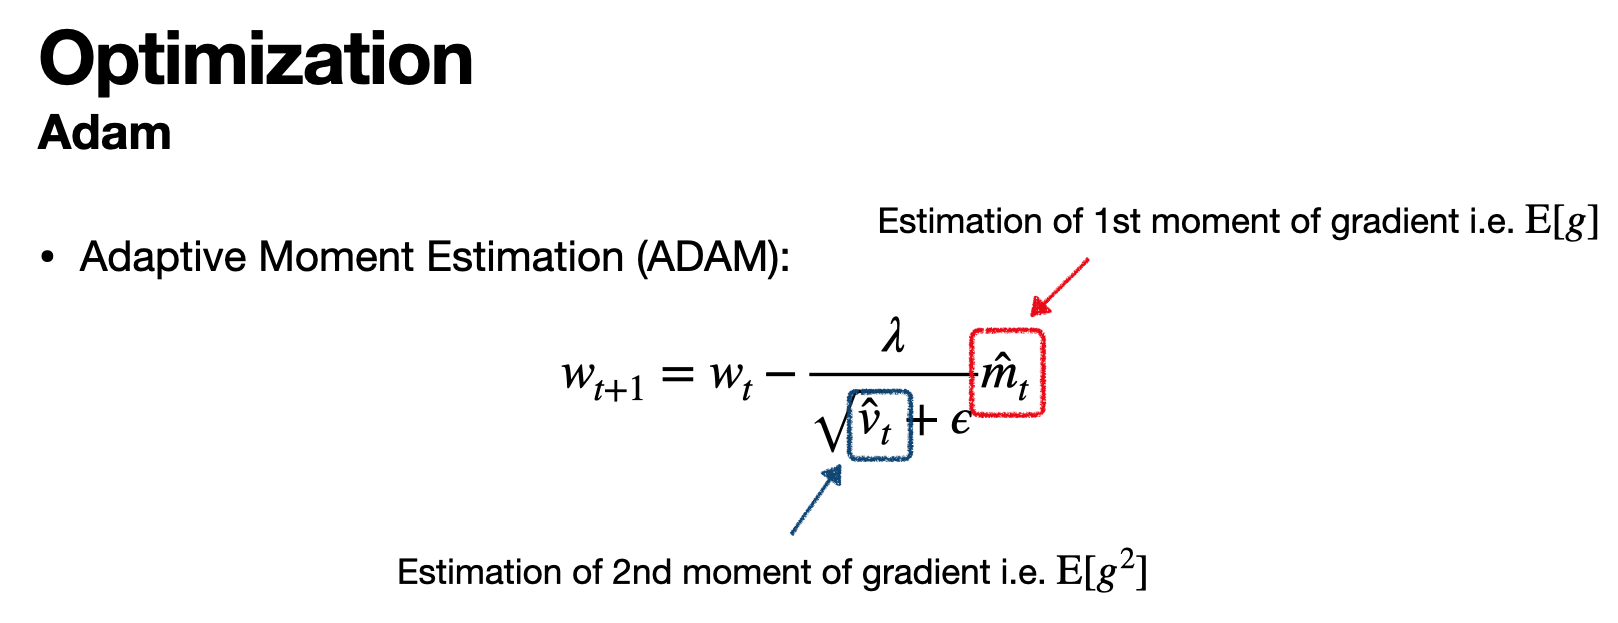 -->


<div>
<center>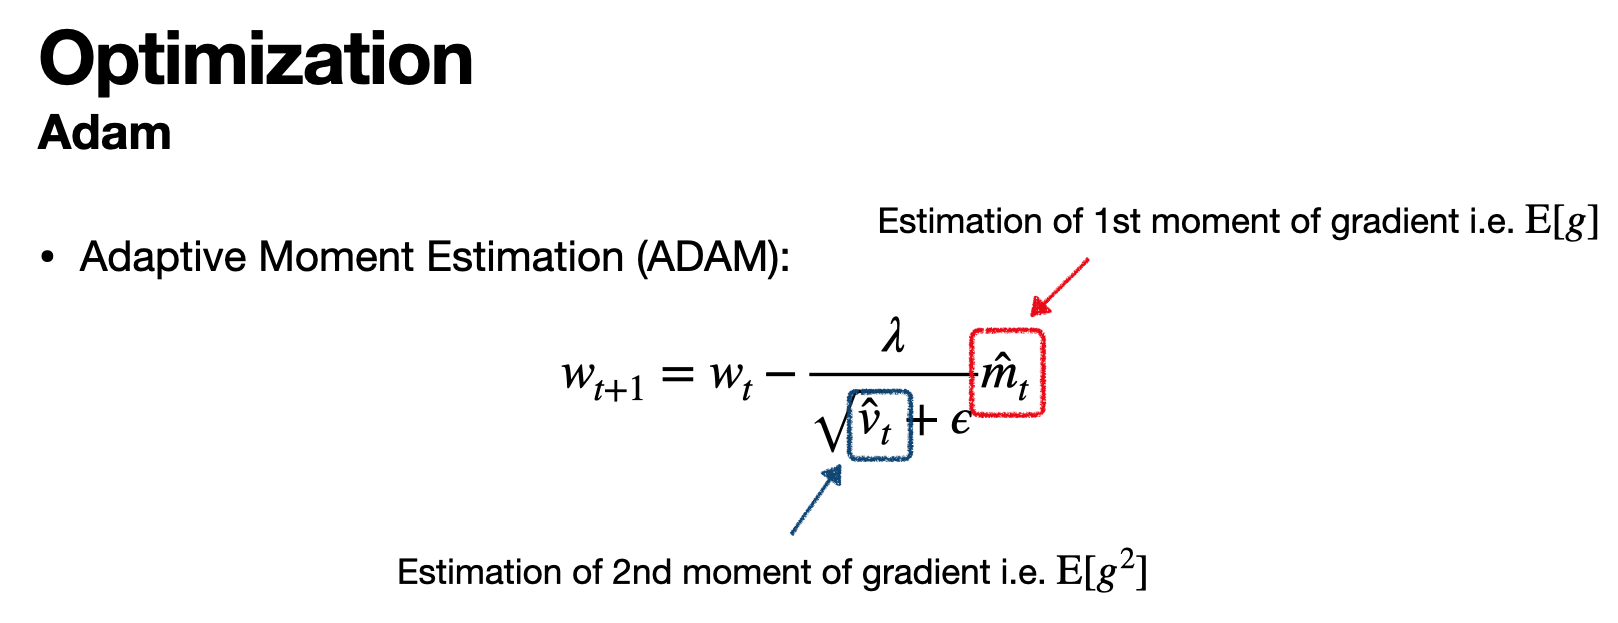</center>
<div>

<!-- 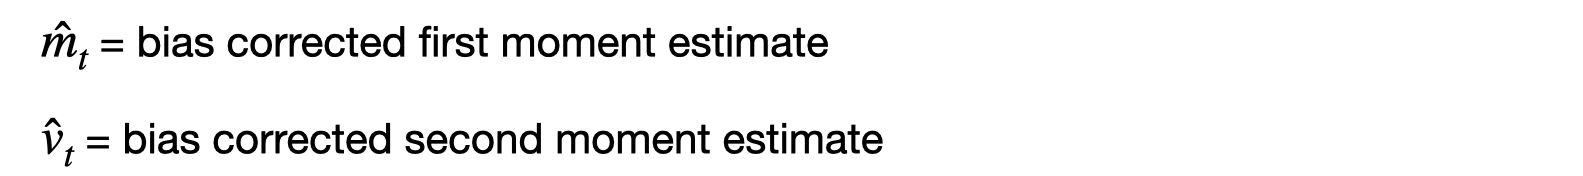 -->

<div>
<center>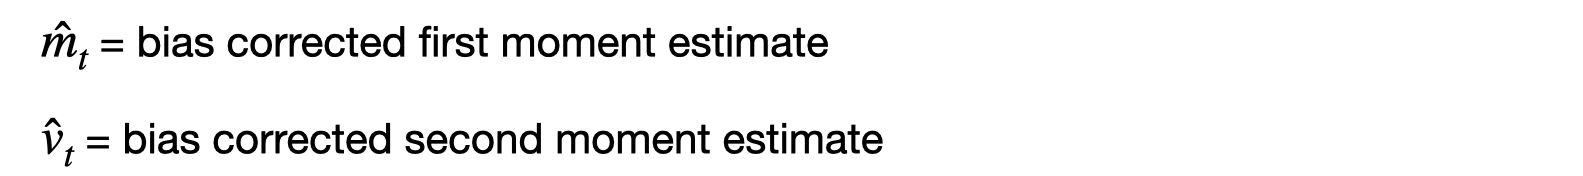</center>
<div>

<!-- 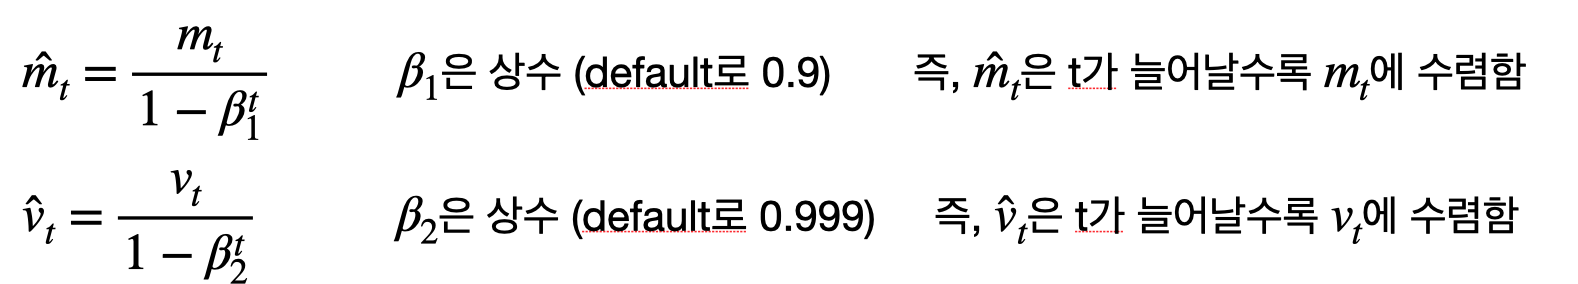 -->

<div>
<center>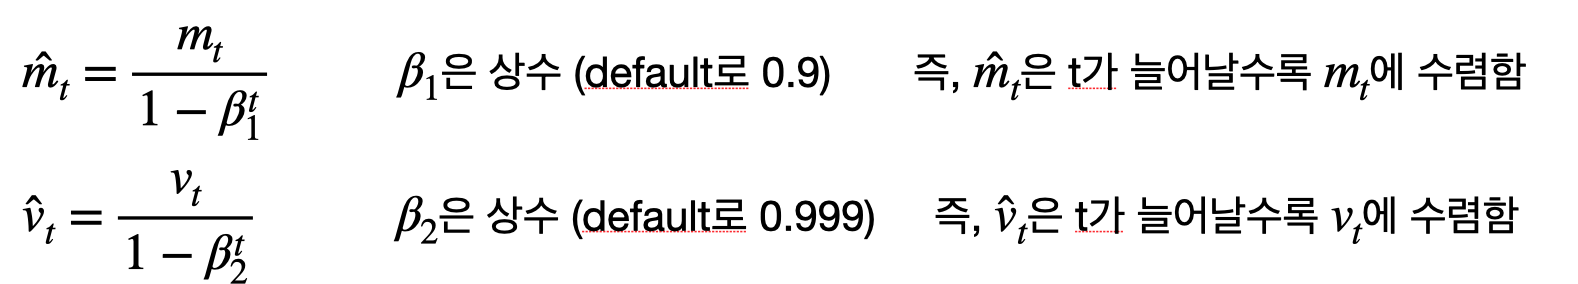</center>
<div>


<!-- 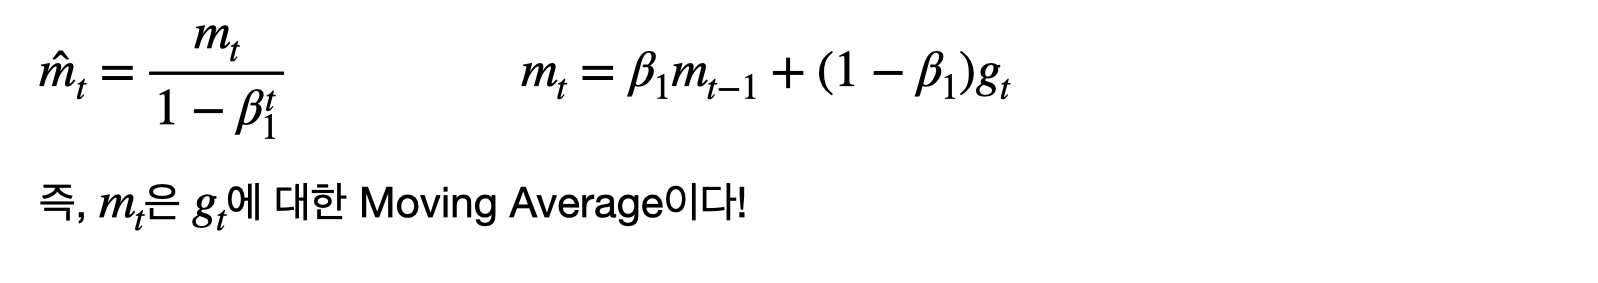 -->

<div>
<center>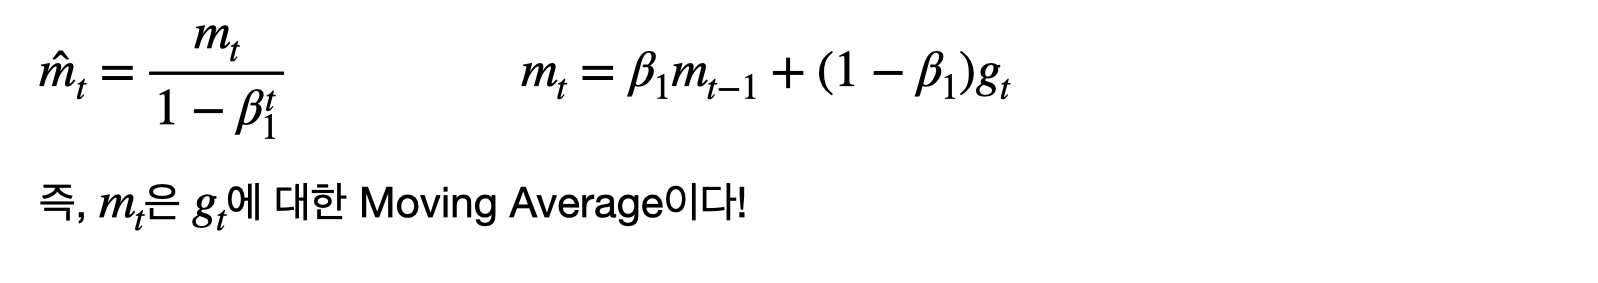</center>
<div>


<!-- 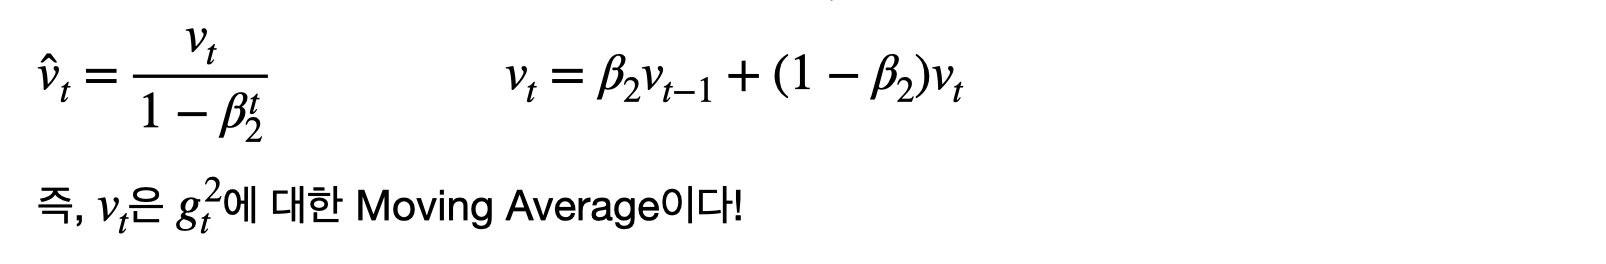 -->

<div>
<center>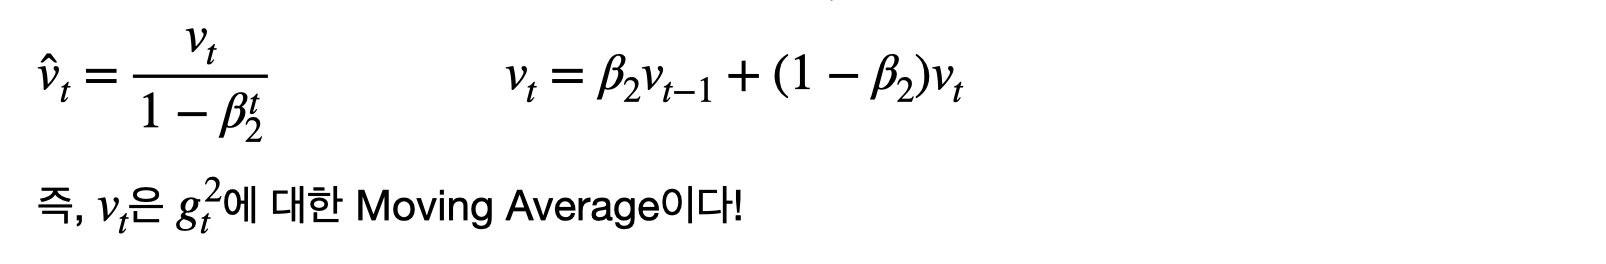</center>
<div>


<!-- 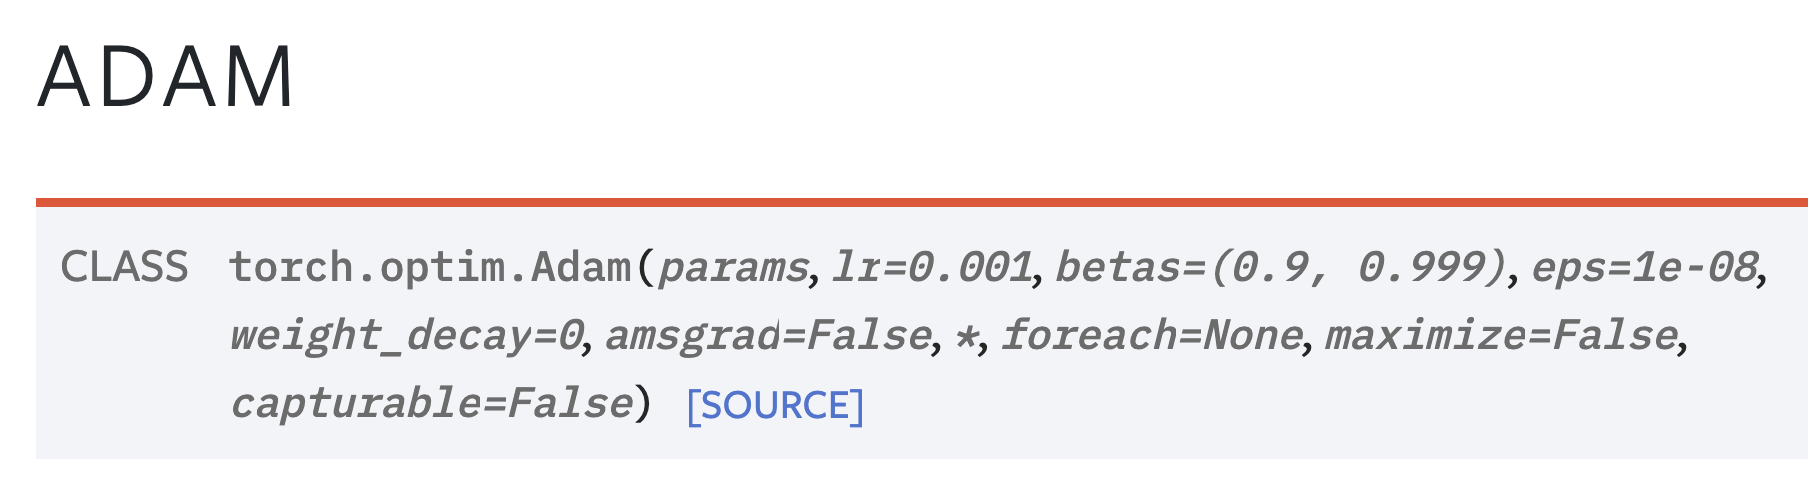
 -->
<div>
<center>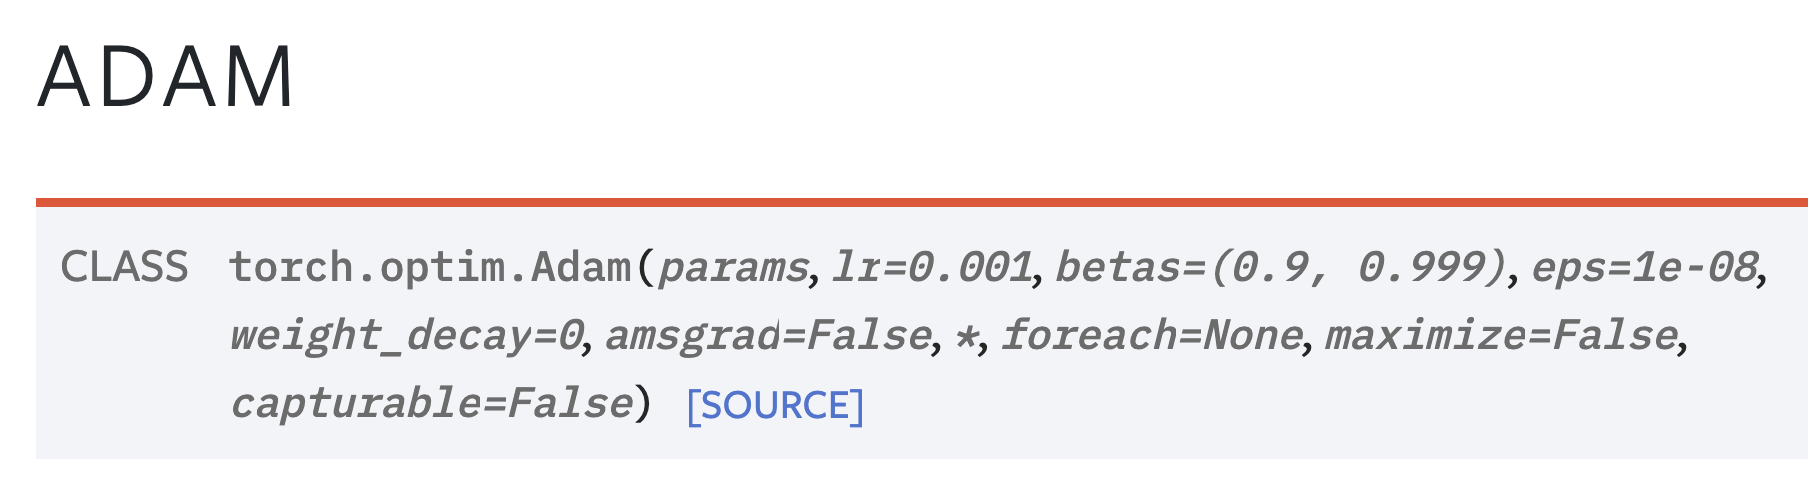</center>
<div>


In [19]:
beta_1=0.9
beta_2=0.999


In [20]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             betas=(beta_1, beta_2))